In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    max_depth=None,            # Maximum depth of each tree
    min_samples_split=20,      # Minimum number of samples to split a node

    min_samples_leaf=1,        # Minimum number of samples in a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    bootstrap=False,            # Whether to use bootstrapping

    random_state=42            # For reproducibility
    )
meta_learner_rf.fit(stacked_features, y_test)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner
final_predictions_rf = meta_learner_rf.predict(stacked_features)

# Evaluate the Random Forest ensemble model
accuracy_rf = accuracy_score(y_test, final_predictions_rf)
report_rf = classification_report(y_test, final_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, final_predictions_rf))


581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step
Random Forest Meta-Learner Accuracy: 99.19%
Classification Report (Random Forest):
               precision    recall  f1-score   support

     anxiety       0.99      0.98      0.99      1999
     bipolar       0.98      0.97      0.98      1941
  depression       0.98      0.99      0.98      1959
      normal       1.00      1.00      1.00     10679
        ptsd       0.99      0.99      0.99      1987

    accuracy                           0.99     18565
   macro avg       0.99      0.99      0.99     18565
weighted avg       0.99      0.99      0.99     18565

Confusion Matrix (Random Forest):
 [[ 1969     8    14     3     5]
 [    4  1886    15    30     6]
 [    7     6  1937     0     9]
 [    0    15     1 10663     0]
 [    5     9    11     2  1960]]


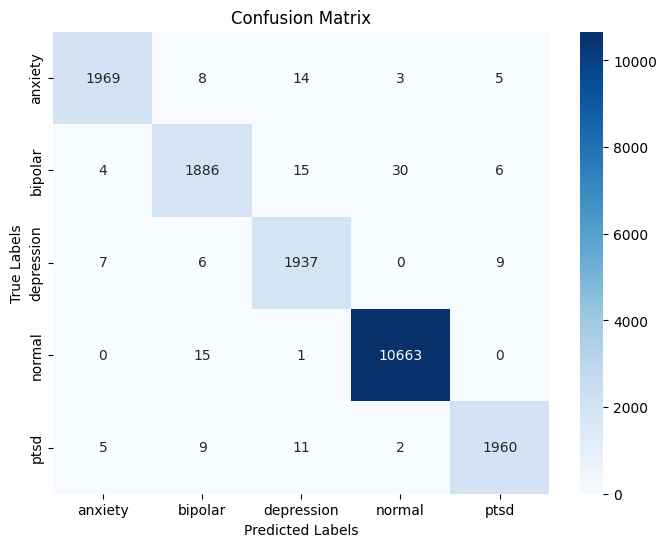

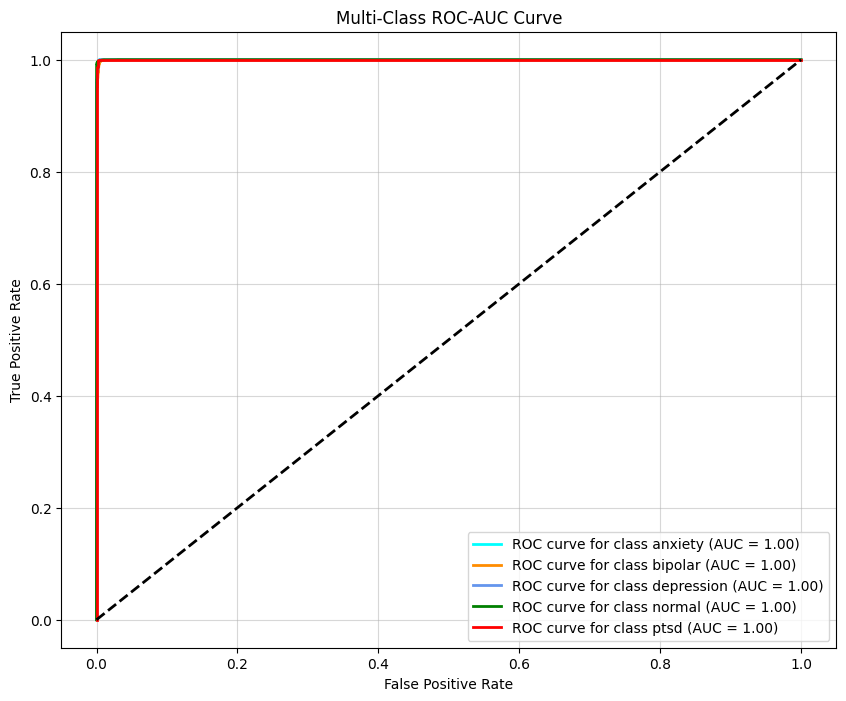

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC-AUC
y_test_binarized = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
final_predictions_proba = meta_learner_rf.predict_proba(stacked_features)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], final_predictions_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC-AUC curve
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title('Multi-Class ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()


In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    n_estimators=3000,         # Number of trees
    max_depth=None,            # Maximum depth of each tree
    min_samples_split=20,      # Minimum number of samples to split a node

    min_samples_leaf=1,        # Minimum number of samples in a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    bootstrap=False,            # Whether to use bootstrapping

    random_state=42            # For reproducibility
    )
meta_learner_rf.fit(stacked_features, y_test)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner
final_predictions_rf = meta_learner_rf.predict(stacked_features)

# Evaluate the Random Forest ensemble model
accuracy_rf = accuracy_score(y_test, final_predictions_rf)
report_rf = classification_report(y_test, final_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, final_predictions_rf))


581/581 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step
Random Forest Meta-Learner Accuracy: 99.16%
Classification Report (Random Forest):
               precision    recall  f1-score   support

     anxiety       0.99      0.98      0.99      1999
     bipolar       0.98      0.97      0.98      1941
  depression       0.98      0.99      0.98      1959
      normal       1.00      1.00      1.00     10679
        ptsd       0.99      0.99      0.99      1987

    accuracy                           0.99     18565
   macro avg       0.99      0.99      0.99     18565
weighted avg       0.99      0.99      0.99     18565

Confusion Matrix (Random Forest):
 [[ 1969     8    15     3     4]
 [    4  1885    16    29     7]
 [    8     8  1933     1     9]
 [    1    16     1 10661     0]
 [    5     8    11     2  1961]]


## Final After Cross Validation Check

In [6]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    max_depth=None,            # Maximum depth of each tree
    min_samples_split=20,      # Minimum number of samples to split a node
    min_samples_leaf=1,        # Minimum number of samples in a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    bootstrap=False,           # Whether to use bootstrapping
    random_state=42            # For reproducibility
)

# Cross-validation for Random Forest meta-learner
cross_val_accuracy = cross_val_score(meta_learner_rf, stacked_features, y_test, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Accuracy: {cross_val_accuracy}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_accuracy) * 100:.2f}%")

# Fit the model to the full training set after cross-validation
meta_learner_rf.fit(stacked_features, y_test)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner
final_predictions_rf = meta_learner_rf.predict(stacked_features)

# Evaluate the Random Forest ensemble model
accuracy_rf = accuracy_score(y_test, final_predictions_rf)
report_rf = classification_report(y_test, final_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, final_predictions_rf))


581/581 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step
Cross-Validation Accuracy: [0.97683814 0.96902774 0.98033935 0.96552653 0.9730676 ]
Mean Cross-Validation Accuracy: 97.30%
Random Forest Meta-Learner Accuracy: 99.19%
Classification Report (Random Forest):
               precision    recall  f1-score   support

     anxiety       0.99      0.98      0.99      1999
     bipolar       0.98      0.97      0.98      1941
  depression       0.98      0.99      0.98      1959
      normal       1.00      1.00      1.00     10679
        ptsd       0.99      0.99      0.99      1987

    accuracy                           0.99     18565
   macro avg       0.99      0.99      0.99     18565
weighted avg       0.99      0.99      0.99     18565

Confusion Matrix (Random Forest):
 [[ 1969     8    14     3     5]
 [    4  1886    15    30     6]
 [    7     6  1937     0     9]
 [    0    15     1 10663     0]
 [    5     9    11     2  1960]]
